In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
# Import packages that will be used
import c2qa
import custom_gates
import numpy as np
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister,QuantumRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library.standard_gates import HGate
from math import pi, ceil
import scipy
from c2qa.operators import CVOperators
from c2qa.qumoderegister import QumodeRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from c2qa.parameterized_unitary_gate import ParameterizedUnitaryGate
from qutip import *

/home/smohapa5


In [10]:
from IPython.display import display
from qutip import (about, basis, coherent, coherent_dm, displace, fock, ket2dm,
                   plot_wigner, squeeze, thermal_dm,destroy)
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, anim_matrix_histogram,
                   anim_fock_distribution)
from numpy import conj

In [23]:
cutoff = 2**6
osc_init = coherent(cutoff,-2) + coherent(cutoff,2)
# print(osc_init.full())

In [31]:
Ust = custom_gates.state_transfer.dv2cv_st_non_abelian(0.29,4,cutoff)
Ust1 = Ust.dag()

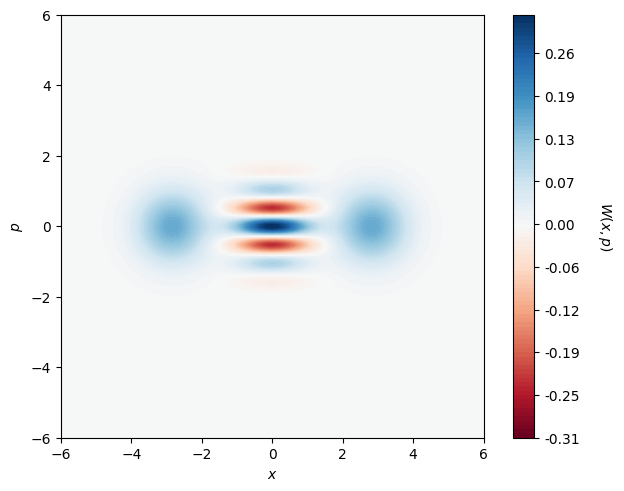

In [25]:
qbm = 4
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode = 6)
qbr = QuantumRegister(1)
qbr1 = QuantumRegister(4)
cr = ClassicalRegister(1)
cr1 = ClassicalRegister(4)
circuit = c2qa.CVCircuit(qmr, qbr1, cr1)
circuit.cv_initialize(osc_init.full(), qmr[0])

state3, result, _ = c2qa.util.simulate(circuit,shots = 1024)
c2qa.wigner.plot_wigner(circuit, state3)

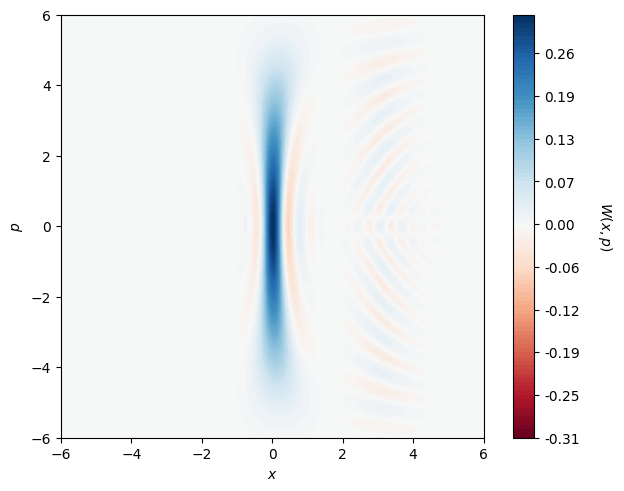

In [26]:
def apply_basis_transformation(circuit, qbr1):
    num_qubits = len(qbr1)
    for i in range(num_qubits):
        circuit.h(qbr1[i])
        if i == num_qubits - 1:  # MSB
            circuit.x(qbr1[i])
            circuit.z(qbr1[i])
        elif i == 0:  # LSB
            circuit.z(qbr1[i])
        else:  # Middle qubits
            circuit.x(qbr1[i])

# Initialize the circuit
qbm = 4
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=6)
qbr1 = QuantumRegister(4)
cr1 = ClassicalRegister(4)
circuit = c2qa.CVCircuit(qmr, qbr1, cr1)

# Initialize the CV qumode
circuit.cv_initialize(osc_init.full(), qmr[0])
circuit.barrier(label='')

# Add the CV-to-DV transfer gate
gate1 = UnitaryGate(Ust1.full(), label='CVtoDV')
circuit.append(gate1, qmr[:] + qbr1[:])

circuit.barrier()

# Apply basis transformation
apply_basis_transformation(circuit, qbr1)

circuit.barrier()

# Simulate and measure
st0 = Statevector.from_instruction(circuit)
for i in range(len(qbr1)):
    circuit.measure(qbr1[i], cr1[-(i + 1)])

state1, result, _ = c2qa.util.simulate(circuit, shots=1024)
c2qa.wigner.plot_wigner(circuit, state1)

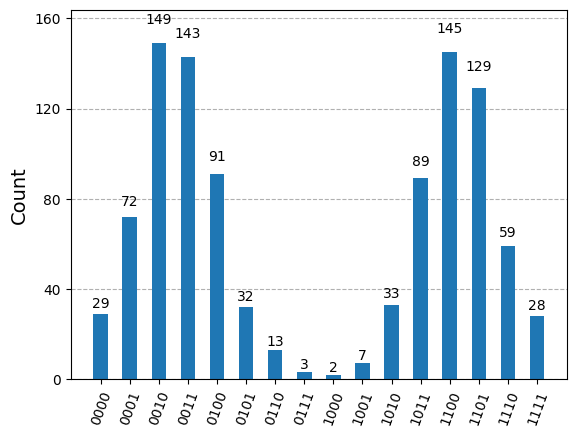

In [27]:
plot_histogram(result.get_counts())

In [28]:
def apply_basis_transformation_reverse(circuit, qbr1):
    num_qubits = len(qbr1)
    for i in range(num_qubits):
        if i == num_qubits - 1:  # MSB
            circuit.z(qbr1[i])
            circuit.x(qbr1[i])
            circuit.h(qbr1[i])
        elif i == 0:  # LSB
            circuit.z(qbr1[i])
            circuit.h(qbr1[i])
        else:  # Middle qubits
            circuit.x(qbr1[i])
            circuit.h(qbr1[i])

# Initialize the circuit
qbm = 4
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=6)
qbr = QuantumRegister(1)
qbr1 = QuantumRegister(4)
cr = ClassicalRegister(1)
cr1 = ClassicalRegister(4)
circuit = c2qa.CVCircuit(qmr, qbr1, cr1)

# Initialize the DV-to-CV state
circuit.initialize(st0, qmr[:] + qbr1[:])

# Apply reversed basis transformation
apply_basis_transformation_reverse(circuit, qbr1)

# Add the DV-to-CV transfer gate
gate1 = UnitaryGate(Ust.full(), label='DVtoCV')
circuit.append(gate1, qmr[:] + qbr1[:])
circuit.barrier()

# Measure the qubits
for i in range(len(qbr1)):
    circuit.measure(qbr1[i], cr1[-(i + 1)])

# circuit.draw('mpl')


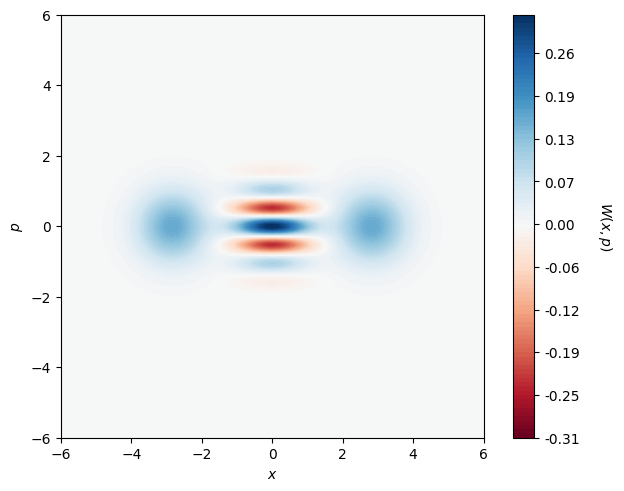

In [29]:
state, result, _ = c2qa.util.simulate(circuit,shots = 1024)
c2qa.wigner.plot_wigner(circuit, state)

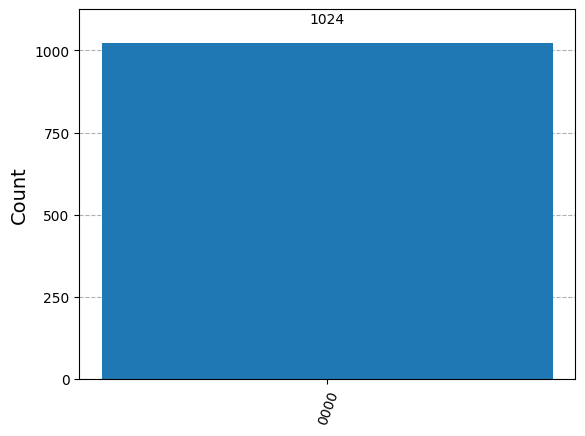

In [30]:
plot_histogram(result.get_counts())